# Fittting STARDIS Example

## Import Necessary Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from stardis.base import run_stardis

from astropy import units as u
from astropy.constants import R_sun, au

from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

## What's in this Notebook?

As you use STARDIS, you may be interested in comparing or fitting a STARDIS simulation to an observed spectra, whether thats for verifying your stellar model or learning more about the star your comparing it to. While there are many ways you could go about doing this, in this notebook is an example of one possible use case of STARDIS, where we will be creating a function to find what abundances of select elements result in the best fitting STARDIS simulation.

This example is designed to highlight one of the many, many uses of STARDIS, rather than be a guide on the best way to go about fitting a simulation. To demonstrating this, we will be doing the following:

- Reading in and cleaning observed spectra data
- Creating a function to take a rolling average of a spectra
- Fitting a STARDIS simulation to observed data using Curve_Fit
- Graphing out best fit simulation, displaying our error margins

## Reading in Observed Data

For this example, we will be using data from our own sun to keep it simple. Specifically we will be using the data from C. Gueymard's ["Revised composite extraterrestrial spectrum based on recent solar irradiance observations"](https://www.sciencedirect.com/science/article/pii/S0038092X1830433X). 

In [2]:
solar_irr_df = pd.read_csv('solar_irradiance_data.txt', sep='\\s+', skiprows=12, names=["Wavelength", "Irradiance", "Std_Dev", "Coeff_Var"]) #we won't be using 'Coeff_Var'

solar_irr_df.replace(-999, pd.NA, inplace=True)

solar_irr_df.dropna(axis = 0, how='any', inplace=True)

fractional_std = np.array(solar_irr_df["Std_Dev"] / solar_irr_df["Irradiance"], dtype=float)

In addition to this standard data cleaning, we will be accounting for the fact that STARDIS simulations show the stellar spectrum as it is at a star's surface, but this data is quite unfortunately not taken from the surface of the sun, but instead from approximatly 1 AU away. While later we will be normalizing both this data and our STARDIS output spectrum, we will use inverse square law here to ensure simpler comparison between out simulation and data.

In [3]:
# Convert the 'Wavelength' column to a Quantity with units of millimeters, then convert to Angstroms
wavelength_quantity = u.Quantity(solar_irr_df['Wavelength'], u.nm)
solarIrr_Wavelength = wavelength_quantity.to(u.AA)

# Similarly for the 'Irradiance' column:
irradiance_quantity = u.Quantity(solar_irr_df['Irradiance'], u.W / u.m**2 / u.nm)
solar_Irr = irradiance_quantity.to(u.erg / u.s / u.cm**2 / u.AA)

# Apply inverse square law conversion
solar_Irr = solar_Irr * ((au) / (R_sun))**2

## Rolling Normalization Function

For this example, we would like the absorption lines of different elements to be the basis of our fitting, giving less attention to any possible difference in continuum between the STARDIS spectra and true spectra. While there are several ways one could compare absorption features like these, such as comparing the Full Width Half Max between simulated and observed, for our purposes we will just be comparing the normalized spectra. To accomplish this normalization, we will use this function below:

In [4]:
def normalize_flux(flux_arr, wavelengths, window=50 * u.Angstrom, std_err=None):
    # Trim the boundaries
    mask = (wavelengths >= (wavelengths.min() + window)) & (wavelengths <= (wavelengths.max() - window))
    target_flux_arr = flux_arr[mask]
    target_wavelengths = wavelengths[mask]

    if std_err is not None:
        std_err_masked = std_err[mask]

    n = len(flux_arr)
    m = len(target_flux_arr)
    
    # Preallocate the normalized flux array
    normalized_flux = np.empty(m)

    # Pre-convert wavelengths to float for faster arithmetic
    wavelengths_float = wavelengths.to(u.Angstrom).value
    target_wavelengths_float = target_wavelengths.to(u.Angstrom).value

    start_idx = 0
    end_idx = 0

    for i, wave in enumerate(target_wavelengths_float):
        lower_bound = wave - window.value
        upper_bound = wave + window.value

        # Move the start index forward to maintain window
        while start_idx < n and wavelengths_float[start_idx] < lower_bound:
            start_idx += 1
        # Move the end index forward to include up to upper_bound
        while end_idx < n and wavelengths_float[end_idx] <= upper_bound:
            end_idx += 1

        window_flux = flux_arr[start_idx:end_idx]
        mean_flux = np.mean(window_flux)
        normalized_flux[i] = target_flux_arr[i] / mean_flux

    if std_err is not None:
        return normalized_flux, target_wavelengths, std_err_masked

    return normalized_flux, target_wavelengths

This function is going to by default take a 50 Angstrom window around each flux data point, and normalize that point use the mean of that window.

## Fitting Function

As we are going to be investigating how we can change the abundance of different elements in our stellar model to best fit our simulation, it may be useful to reference the [Changing Parameters documentation](../Changing_Parameters/Changing_Parameters.ipynb) to see how we can change these abundances on the fly when running STARDIS. 

While you can reference the comments and docstring of this function for an idea of how it works, in short it will take a specified range of wavelengths of your normalized observed data before using SciPy's `curve_fit` to create many simulations, each time changing our abundance factors to try and find the factors that make our best fitting model. 

It is also to note we use SciPy's `gaussian_filter1d` here to emulate the instrumental effects and spectral resolution of the telescopes/detectors used to collect this data. The sigma used here, 616, was chosen by both visually comparing our resulting STARDIS spectra to our observed data as well as by running a fitting script to find a 'best' sigma. For a more rigorous analysis using `gaussian_filter1d` or similar function, you would want to consider the telescope(s) used to collect your data and calculate your spectra resolution to inform your choice of sigma.

In [5]:
def curve_fit_rescaling(obs_wavelengths, obs_flux, obs_fractional_std, elements, bounds=None, window=50 * u.Angstrom):
    """
    Fits STARDIS nuclide rescaling factors to observed spectral flux using curve fitting.

    Parameters:
    -----------
    obs_wavelengths : Quantity array
        Wavelengths of the observed spectrum (with units, e.g., Angstrom).

    obs_flux : array-like
        Observed flux values corresponding to the input wavelengths.

    obs_fractional_std : array-like
        Fractional standard deviation (error / flux) for each observed point.

    elements : list of str
        List of element symbols (e.g., ["Fe", "Mg"]) to include in the rescaling.

    bounds : tuple, optional
        Tuple specifying the fitting region (start, end) in Angstroms.
        If None, the full range of obs_wavelengths will be used.

    window : Quantity, optional
        Smoothing/normalization window for flux normalization (default is 50 Angstrom).

    Returns:
    --------
    optimal_factors : dict
        Best-fit rescaling factors for each element.

    fitting_sigmas_dict : dict
        Standard deviations (1σ uncertainties) of the fitted factors.

    lower_uncertainty : dict
        Dictionary of lower 1σ bounds: factor - sigma for each element.

    upper_uncertainty : dict
        Dictionary of upper 1σ bounds: factor + sigma for each element.
    """

    # --- Define wavelength fitting bounds ---
    if bounds is None:
        left_bound = obs_wavelengths[0].value
        right_bound = obs_wavelengths[-1].value
    else:
        left_bound = bounds[0]
        right_bound = bounds[1]

    # --- Normalize observed flux ---
    obs_flux, obs_wavelengths, obs_fractional_std = normalize_flux(
        flux_arr=obs_flux,
        wavelengths=obs_wavelengths,
        window=window,
        std_err=obs_fractional_std
    )
    obs_flux = np.array(obs_flux)

    # --- Create tracing wavelength grid for simulation ---
    step = 0.01
    num_points = int((right_bound - left_bound) / step) + 1
    tracing_lambdas = np.linspace(
        (left_bound - window.value),
        (right_bound + window.value),
        num_points
    ) * u.Angstrom

    # --- Mask observed data to fitting bounds ---
    mask = (obs_wavelengths.value >= left_bound) & (obs_wavelengths.value <= right_bound)
    obs_flux_m = obs_flux[mask]
    obs_wavelengths_m = obs_wavelengths[mask].value
    obs_fractional_std_m = obs_fractional_std[mask]

    # --- Define simulation function for curve fitting ---
    def Stardis_simulation(wavelengths, *factors):
        factor_dict = dict(zip(elements, factors))
        print(f"Running STARDIS for factors: {factor_dict}")

        sim = run_stardis(
            'sun_vald.yml',
            tracing_lambdas,
            add_config_dict={
                'input_model.nuclide_rescaling_dict': factor_dict,
            }
        )
        sim_spectra_smoothed = gaussian_filter1d(sim.spectrum_lambda, 616)
        sim_spectra_norm, sim_wavelength_norm = normalize_flux(
            sim_spectra_smoothed, sim.lambdas, window=window
        )
        sim_wavelength_norm = sim_wavelength_norm.value

        interpolated_flux = np.interp(wavelengths, sim_wavelength_norm, sim_spectra_norm)
        return interpolated_flux

    # --- Set initial guesses and bounds for each element ---
    initial_guess = [1.0] * len(elements)
    lower_bounds = [0.5] * len(elements)
    upper_bounds = [1.5] * len(elements)

    # --- Perform curve fitting ---
    popt, pcov = curve_fit(
        Stardis_simulation,
        xdata=np.array(obs_wavelengths_m),
        ydata=np.array(obs_flux_m),
        p0=initial_guess,
        bounds=(lower_bounds, upper_bounds),
        sigma=np.array(obs_fractional_std_m * obs_flux_m),
        absolute_sigma=True,
    )

    # --- Extract optimal factors and uncertainties ---
    fitting_sigmas = np.sqrt(np.diag(pcov))
    optimal_factors = dict(zip(elements, popt))
    fitting_sigmas_dict = dict(zip(elements, fitting_sigmas))

    lower_uncertainty = {el: val - sig for el, val, sig in zip(elements, popt, fitting_sigmas)}
    upper_uncertainty = {el: val + sig for el, val, sig in zip(elements, popt, fitting_sigmas)}

    return optimal_factors, fitting_sigmas_dict, lower_uncertainty, upper_uncertainty

## Plotting STARDIS Spectra

To see how our fitting function worked, here is the function we will use our `curve_fit_rescaling` function to create and plot a fitted STARDIS spectra. To show the error on our found abundance factors, we will be finding the spectra that result from using all factors 1 standard deviation above out 'best fit' factors and 1 standard deviation below them.

In [6]:
def plot_stardis_fit(elements, bounds, window):
    """
    Fits STARDIS model to observed solar irradiance and plots simulation vs observation with uncertainty.

    Parameters:
    -----------
    elements : list of str
        List of element symbols to include in the nuclide rescaling (e.g., ['Mg', 'Fe']).

    bounds : tuple
        Tuple of wavelength range to fit (start_wavelength, end_wavelength) in Angstroms.

    window : Quantity
        Smoothing window for normalization (e.g., 50 * u.Angstrom).

    Returns:
    --------
    None
    Prints optimal fit parameters and shows a plot comparing STARDIS output with observed data.
    """

    left_bound = bounds[0]
    right_bound = bounds[1]
    step = 0.01
    num_points = int((right_bound - left_bound) / step) + 1

    tracing_lambdas = np.linspace(
        left_bound - window.value,
        right_bound + window.value,
        num_points
    ) * u.Angstrom

    def run_and_process_stardis(factor_dict, tracing_lambdas):
        """Runs STARDIS, smooths and normalizes output, and returns wavelengths and flux."""
        sim = run_stardis(
            'sun_vald.yml',
            tracing_lambdas,
            add_config_dict={'input_model.nuclide_rescaling_dict': factor_dict}
        )
        smoothed_flux = gaussian_filter1d(sim.spectrum_lambda, 616)
        norm_flux, norm_wavelengths = normalize_flux(smoothed_flux, sim.lambdas, window=window)
        return norm_wavelengths.value, norm_flux

    def prepare_observed_data(wavelengths, flux, std_err):
        """Normalizes and masks observed solar irradiance data."""
        norm_flux, norm_wav, norm_std = normalize_flux(
            flux_arr=flux,
            wavelengths=wavelengths,
            window=window,
            std_err=std_err
        )
        mask = (norm_wav.value >= left_bound) & (norm_wav.value <= right_bound)
        return norm_wav[mask], norm_flux[mask], norm_std[mask]

    # Run curve fitting
    factor_dict, factor_sigmas, lower_factors, upper_factors = curve_fit_rescaling(
        obs_wavelengths=solarIrr_Wavelength,
        obs_flux=solar_Irr,
        obs_fractional_std=fractional_std,
        elements=elements,
        bounds=bounds,
        window=window
    )

    # Simulate STARDIS for best fit and ±1σ bounds
    wav_sim, flux_sim = run_and_process_stardis(factor_dict, tracing_lambdas)
    wav_lower, flux_lower = run_and_process_stardis(lower_factors, tracing_lambdas)
    wav_upper, flux_upper = run_and_process_stardis(upper_factors, tracing_lambdas)

    # Prepare observed solar irradiance
    wav_obs, flux_obs, std_obs = prepare_observed_data(solarIrr_Wavelength, solar_Irr, fractional_std)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(wav_sim, flux_sim, label='STARDIS Simulation', color='blue')
    plt.fill_between(wav_sim, flux_lower, flux_upper, color='darkgrey', alpha=0.4, label='1 Sigma Uncertainty Range')

    plt.errorbar(
        wav_obs, flux_obs, yerr=std_obs * flux_obs,
        fmt='o', capsize=3, elinewidth=1.2, markeredgewidth=0.8,
        markersize=5, alpha=0.8, color='darkorange', ecolor='gray',
        label='Solar Irradiance'
    )

    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Normalized Flux')
    plt.title(f'STARDIS Simulation (fitted for {', '.join(factor_dict.keys())}) vs Solar Irradiance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print results
    print("Optimal factors:")
    for element in elements:
        print(f"{element}: {factor_dict[element]:.4f} ± {factor_sigmas[element]:.4f} "
              f"(lower: {lower_factors[element]:.4f}, upper: {upper_factors[element]:.4f})")

## Results

Now its time to see how our functions turned out! remember, this example isn't designed to be the best way to go about fitting metalicity or element abundances, but as instead an example of the uses of STARDIS and to maybe give you inspiration on or a starting place for your own work.

Also note, as we are using a MARCS solar model designed to be that of the sun, we would expect our factors to be around 1, as the model should not be too far off. now without further adieu...

Running STARDIS for factors: {'Mg': 1.0, 'Fe': 1.0}


Running STARDIS for factors: {'Mg': 1.0000000149011612, 'Fe': 1.0}
Running STARDIS for factors: {'Mg': 1.0, 'Fe': 1.0000000149011612}


Running STARDIS for factors: {'Mg': 0.9181741440390521, 'Fe': 1.0572849645998363}


Running STARDIS for factors: {'Mg': 0.9181741589402133, 'Fe': 1.0572849645998363}


Running STARDIS for factors: {'Mg': 0.9181741440390521, 'Fe': 1.05728498035461}


Running STARDIS for factors: {'Mg': 0.9038195623407479, 'Fe': 1.0622907718065993}


Running STARDIS for factors: {'Mg': 0.9038195772419091, 'Fe': 1.0622907718065993}
Running STARDIS for factors: {'Mg': 0.9038195623407479, 'Fe': 1.0622907876359653}


Running STARDIS for factors: {'Mg': 0.9033081562958316, 'Fe': 1.0621900871947525}


Running STARDIS for factors: {'Mg': 0.9033081711969928, 'Fe': 1.0621900871947525}


Running STARDIS for factors: {'Mg': 0.9033081562958316, 'Fe': 1.0621901030226182}


Running STARDIS for factors: {'Mg': 0.9033291329307168, 'Fe': 1.0622174907390654}


Running STARDIS for factors: {'Mg': 0.9033152468485647, 'Fe': 1.062195584845369}


Running STARDIS for factors: {'Mg': 0.9033152617497259, 'Fe': 1.062195584845369}


Running STARDIS for factors: {'Mg': 0.9033152468485647, 'Fe': 1.0621956006733166}


Running STARDIS for factors: {'Mg': 0.9033156537294925, 'Fe': 1.0621932978611863}


Running STARDIS for factors: {'Mg': 0.9033153509087255, 'Fe': 1.0621950134962101}


Running STARDIS for factors: {'Mg': 0.9033152730116564, 'Fe': 1.06219544203356}


Running STARDIS for factors: {'Mg': 0.9033152533986193, 'Fe': 1.06219554914402}


Running STARDIS for factors: {'Mg': 0.9033152484866589, 'Fe': 1.0621955759201323}


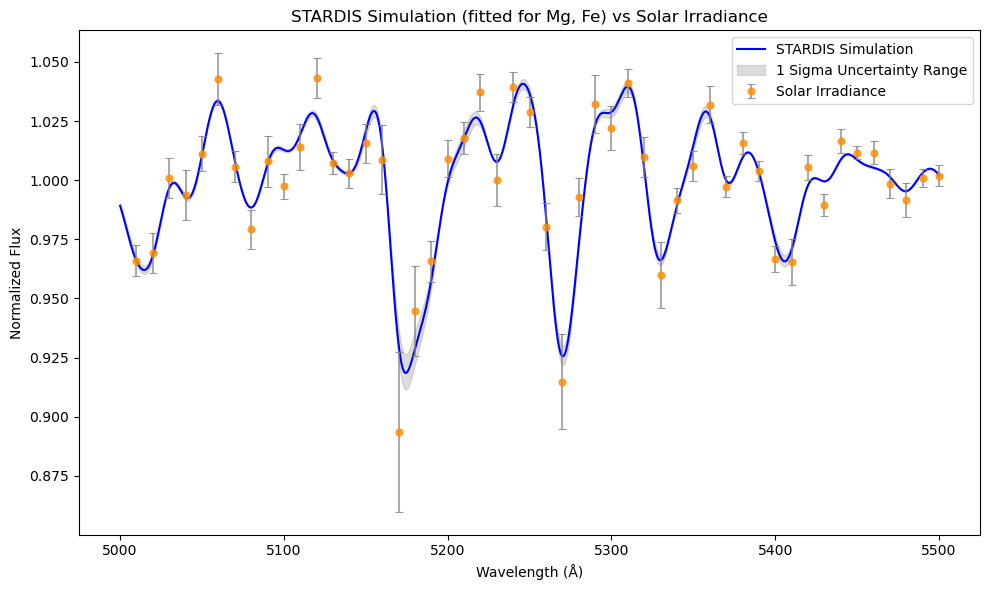

Optimal factors:
Mg: 0.9033 ± 0.1367 (lower: 0.7666, upper: 1.0400)
Fe: 1.0622 ± 0.1706 (lower: 0.8916, upper: 1.2328)


In [7]:
plot_stardis_fit(elements=["Mg", "Fe"], bounds=(5000, 5500), window=50 * u.Angstrom)